In [ ]:
"""
Created on July, 2024

@author: Weronika Golletz
@author: Czcibor Ciostek

Womanium Quantum + AI Project
"""

In [1]:
from classiq import *
from classiq.execution import ExecutionPreferences
from classiq.execution import ExecutionSession

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

In [2]:
# Plots settings
WIDTH = 5
HEIGHT = 3

SMALLER_SIZE = 11
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rcParams['text.usetex'] = True
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

# 1. Select a paper

We select the paper ["Evidence for the utility of quantum computing before fault tolerance"](https://www.nature.com/articles/s41586-023-06096-3) written by Y. Kim, et.
It demonstrates that quantum computers can offer practical advantages even before achieving full fault tolerance, particularly in solving problems that exceed the capabilities of classical computers. The authors focus on the Trotterized time evolution of a two-dimensional transverse-field Ising model and show that quantum computations, based on the expectation value of magnetization, can extend beyond the size of Hilbert space manageable by classical methods.

# 2. Toy model

In [3]:
# Parameters
N = 4           # Number of spins
J = 1.0         # Interaction strength
h = -3.0        # Transverse field strength

*Toy model:* one-dimensional (1D) transverse-field Ising model without periodic boundary conditions with $N=4$ spins

*Steps*

1. Simulate the evolution of the system using the exact approach, and calculate the magnetisation for the evolved state.
2. Simulate the evolution of the system using classicaly simulated Trotter-Suzuki decomposition, and calculate the magnetisation for the evolved state.
3. Simulate the evolution of the system using the Trotter-Suzuki decomposition; this time as a quantum calculation on a simulated quantum hardware, and calculate the magnetisation for the evolved state. 

------------
**Introduction**

As the toy model, we consider a one-dimensional transverse-field Ising model without periodic boundary condition with $N=4$ spins. The system is represented by the Hamiltonian:

$$H = -J \sum_{j=1}^{N-1} \sigma_j^z \sigma_{j+1}^z + h \sum_j^N \sigma_j^z,$$

where $\sigma^z_j$ and $\sigma_j^x$ are the Pauli matrices corresponding to the $z$- and $x$-components of the spin at site $j$. $J$ is the coupling constante between neighboring spins, $h$ is the strength of the transverse magnetic field, and $N$ is the number of spins in the chain. The Hamiltonian for $N=4$ spins has the following explicit form:

$$H = -J (\sigma^z_1 \otimes \sigma^z_2 \otimes I_3 \otimes I_4
+I_1 \otimes \sigma^z_2 \otimes \sigma^z_3 \otimes I_4
+I_1 \otimes I_2 \otimes \sigma^z_3 \otimes \sigma^z_4
) \\+ h (\sigma^x_1 \otimes I_2 \otimes I_3 \otimes I_4
+ I_1 \otimes \sigma^x_2 \otimes I_3 \otimes I_4
\\+ I_1 \otimes I_2 \otimes \sigma^x_3 \otimes I_4
+ I_1 \otimes I_2 \otimes I_3 \otimes \sigma^x_4).$$

The Ising Hamiltonian captures the competition between the nearest-neighbor spin-spin interaction along the $z$-axis and the transverse magnetic field along the $x$-axis. The critical behavior and phase transtition of the system can be analyzed by varying the ratio $h/J$,
where the system undergoes a quantum phase transtion at a critical value of this ration, separating the ferromagnetic phase (low $h/J$) from the paramagnetic phase (high $h/J$).

In our study of the 1D transverse field Ising model, we do not focus on the phase transition aspects, but rather on the dynamics of the system, particularly how the magnetization evolves over time. 

(a) Initially, we employ the **exact evolution** of the system's state via the evolution operator to calculate average time-dependent magnetization:
$$ \langle M(t) \rangle = \frac{1}{N} 
\sum_{j=1}^N \langle \sigma_j^z\rangle,$$
with respect to the evolved state $\psi(t)$.

(b) Subsequently, we transition to approximating the dynamics using the **Trotter-Suzuki decomposition**, which allows us to simulate the system more feasibly on classical computers. 

(c) Further advancing our approach, we implement the Trotter-Suzuki method on a quantum computing platform, specifically using the Classiq platform, to explore the potential advantages and efficiencies that quantum computation may offer in simulating complex quantum systems.

## 2.1 Exact dynamics of 1D Ising model

The exact time evolution of the quantum state is governed by the time evolution operator 
$U(t)$, which is defined as:
$$U(t) = e^{-iHt},$$
 where we set the reduced Planck's constant $\hbar=1$, and $H$ is the Hamiltonian of the system, $t$ represents time.
This operator acts on the initial quantum state of the system to yield the state at any subsequent time t.

----------------------------------
Implementation steps:
1. Define the Hamiltonian matrix.
2. Choose an initial quantum state $\psi(t=0)$ for the system; here we choose the state $|0\rangle^{\otimes N}$.
3. Compute the time evolution operator $U(t)$.
4. Apply $U(t)$ to $\psi(t=0)$ to find the state at any time $t$.

Comments:

While exact time evolution is conceptually the most accurate method for simulating quantum dynamics, its practical application is limited to smaller systems due to the exponential scaling of computational demands with system size. For larger systems, approximate methods or quantum simulations become necessary to manage this computational complexity. However, exact methods are crucial for benchmarking in small systems, providing a foundation that can be extended to more complex approximations in larger systems.

In [4]:
# Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
# Identity matrix
I = np.eye(2, dtype=complex)


def construct_hamiltonian(N, J, h):
    """
    Construct the Hamiltonian for the 1D Ising model in a transverse field

    Input
    -----
    N (int): number of spins
    J (float): coupling strength
    h (float): external magnetic field strength

    Output
    ------
    H (np.array): matrix that represents the 1D transverse-field Ising model 
    """

    H = np.zeros((2**N, 2**N), dtype=complex)

    # H_X term of the Hamiltonian
    for i in range(N):
        operators = [I]*N
        operators[i] = sigma_x
        term = operators[0]
        for op in operators[1:]:
            term = np.kron(term,op)
        H += h * term

    # X_ZZ term of the Hamiltonian
    for i in range(N-1):
        operators = [I]*N
        operators[i] = sigma_z
        operators[i+1] = sigma_z
        term = operators[0]
        for op in operators[1:]:
            term = np.kron(term,op)
        H -= J * term

    return H

def compute_magnetization(state, N):
    """
    Compute the magnetization for the given state.

    Input
    -----
    state (np.array): state for which the magnetization is calculated
    N (int): number of spins

    Output
    ------
    (float): average magnetization for a given state
    """
    magnetization = 0
    for i in range(N):
        operators = [I]*N
        operators[i] = sigma_z
        term = operators[0]
        for op in operators[1:]:
            term = np.kron(term, op)
        magnetization += np.real(np.dot(state.conj().T, np.dot(term, state)))
    return magnetization / N

def bit_rep(num:int,N:int) -> str:
    """
    Binary representation of the given integer 'num', 
    padded to length 'N' of the system 

    Input
    -----
    num (int): number that is converted to binary
    N (int): number of spins 
    
    Output
    ------
    (str): binary number representation
    """
    return bin(num)[2:].zfill(N)

def generate_basis(N:int) -> list[str]:
    """
    Generates a basis spanning the Hilbert space of N spins

    Input
    -----
    N (int): number of spins

    Output
    ------
    (list(str)): list of the basis states
    """
    nstates = 2**N
    basis = []
    for i in range(nstates):
        basis.append(bit_rep(i, N))
    return basis

Basis for N=4: ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


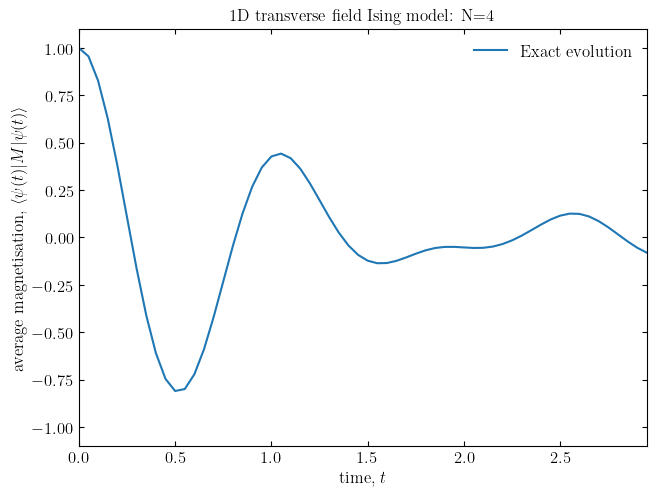

In [5]:
# Parameters
t_max = 3     # Maximum time
dt = 0.05       # Time step

# Print the basis
print(f"Basis for N={N}: {generate_basis(N)}")

# Initial state: all spins up
initial_state = np.zeros(2**N, dtype=complex)
initial_state[0] = 1.0

# Construct the Hamiltonian
H = construct_hamiltonian(N, J, h)

# Time evolution and magnetization calculation
times = np.arange(0, t_max, dt)
magnetizations_exact = np.zeros(len(times))

for (id,t) in enumerate(times):
    U = expm(-1j * H * t)
    state_t = np.dot(U, initial_state)
    magnetizations_exact[id] = compute_magnetization(state_t,N)

# Plot
plt.plot(times,magnetizations_exact,label=f"Exact evolution")
plt.xlim(0,times[-1])
plt.ylim(-1.1,1.1)
plt.tick_params(direction='in')
plt.tick_params(top=True, right=True, which='major')
plt.legend(frameon=False)
plt.xlabel(r'time, $t$')
plt.ylabel(r"average magnetisation, $\langle \psi(t)| M | \psi(t) \rangle$")
plt.title("1D transverse field Ising model: N=4")
plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=0.5)
# plt.savefig("name.png",dpi=300)
# plt.savefig("name.svg")
plt.show()

## 2.2 Approximated dynamics of 1D Ising model (classical method)

The Trotter-Suzuki decomposition is a method used in quantum simulations to approximate the time evolution operator $e^{-iHt}$ as a product of simpler unitary matrices.
For small time steps $\Delta t = t/M$ the first-order Trotter-Suzuki decomposition is for the transverse field Ising model:
$$e^{-iH t} \approx (e^{-iH_Z \Delta t}e^{-iH_X \Delta t})^M,$$
where 

$H_Z = -J \sum_{\langle j,k \rangle} \sigma_j^{z} \sigma_k^z$,

$H_X = h \sum_{j=1}^N \sigma_j^{x}$.

--------------------------------
Implementation steps:
1. Define the matrix representation of the Pauli matrices and then construct $H_Z$ and $H_X$.
2. Compute the exponential of these matrices for the time evolution.
3. Apply these operators iteratively to simulate the time evolution of an intial state.

In [6]:
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
I = np.eye(2, dtype=complex)

def construct_h_zz(N, J):
    """
    Construct H_ZZ term of the 1D transverse-field Ising model.
    
    Input
    -----
    N (int): number of spins
    J (float): coupling constant strength
    
    Output:
    h_zz (np.array): matrix that represents the H_ZZ term of the Hamiltonian
    """
    h_zz = np.zeros((2**N, 2**N), dtype=complex)
    for i in range(N - 1):
        operators = [I]*N
        operators[i] = sigma_z
        operators[i + 1] = sigma_z
        term = operators[0]
        for op in operators[1:]:
            term = np.kron(term, op)
        h_zz += term
    return -J * h_zz 

def construct_h_x(N, h):
    """
    Construct H_X term of the 1D transverse-field Ising model.
    
    Input
    -----
    N (int): number of spins
    h (float): transverse magnetic field strength
    
    Output:
    h_x (np.array): matrix that represents the H_X term of the Hamiltonian
    """
    h_x = np.zeros((2**N, 2**N), dtype=complex)
    for i in range(N):
        operators = [I]*N
        operators[i] = sigma_x
        term = operators[0]
        for op in operators[1:]:
            term = np.kron(term, op)
        h_x += term
    return h * h_x

def compute_magnetization(state, N):
    """
    Compute the magnetization for the given state.

    Input
    -----
    state (np.array): state for which the magnetization is calculated
    N (int): number of spins

    Output
    ------
    (float): average magnetization for a given state
    """
    magnetization = 0
    for i in range(N):
        operators = [I]*N
        operators[i] = sigma_z
        term = operators[0]
        for op in operators[1:]:
            term = np.kron(term, op)
        magnetization += np.real(np.dot(state.conj().T, np.dot(term, state)))
    return magnetization / N

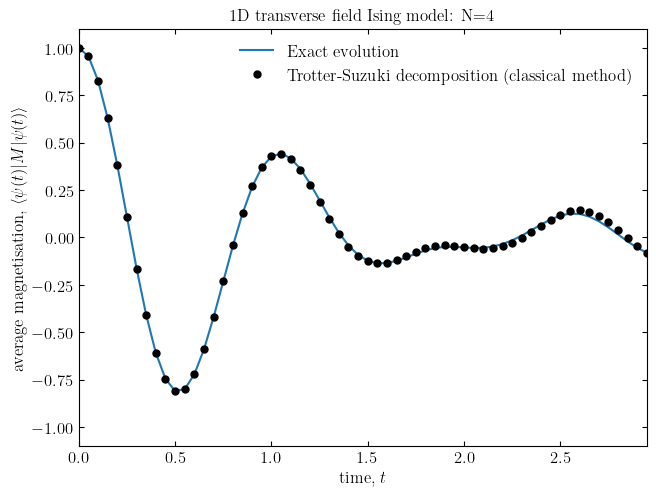

In [7]:
# Parameters
t_max = 3       # maximum time

# Initial state: all spins up
initial_state = np.zeros(2**N, dtype=complex)
initial_state[0] = 1.0

h_x = construct_h_x(N, h)
h_zz = construct_h_zz(N, J)

Ux = expm(-1j * h_x * dt)
Uzz = expm(-1j * h_zz * dt)

state_t = initial_state

t_maxs = np.arange(0,3,0.05)
magnetizations_TS = np.zeros(len(t_maxs))
for (id,t_max) in enumerate(t_maxs):
    M = 15          # repertitions
    dt = t_max/M    # time step

    Ux = expm(-1j * h_x * dt)
    Uzz = expm(-1j * h_zz * dt)

    initial_state = np.zeros(2**N, dtype=complex)
    initial_state[0] = 1.0
    state_t = initial_state
    for m in range(M):
        state_t = np.dot(Uzz, np.dot(Ux, state_t))

    magnetization = compute_magnetization(state_t, N)
    magnetizations_TS[id] = magnetization

# plot
plt.plot(times,magnetizations_exact,label=f"Exact evolution")
plt.plot(t_maxs,magnetizations_TS,label=f"Trotter-Suzuki decomposition (classical method)", lw=0, marker='o',color='k',markersize=5)
plt.xlim(0,times[-1])
plt.ylim(-1.1,1.1)
plt.tick_params(direction='in')
plt.tick_params(top=True, right=True, which='major')
plt.legend(frameon=False)
plt.xlabel(r'time, $t$')
plt.ylabel(r"average magnetisation, $\langle \psi(t)| M | \psi(t) \rangle$")
plt.title("1D transverse field Ising model: N=4")
plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=0.5)
# plt.savefig("name.png",dpi=300)
# plt.savefig("name.svg")
plt.show()

## 2.3 Approximated dynamics of 1D Ising model (quantum simulation)

In [55]:
# Parameters of the Suzuki-Trotter decomposition
REPETITIONS = 1000

In [56]:
def get_repetitions():
  """
  Just returns the global variable repetitions; 
  allows us to control the 'repetitions' parameter 
  as a funciton variable.
  """
  return REPETITIONS

def mz_state(basis):
    """
    Calculate the magnetization of a given state in the basis.

    Input
    -----
    basis (str): a state from the basis
    N (int): number of spins

    Output
    ------
    mz (int): magnetization of a given state
    """
    mz = 0
    for id in range(len(basis)):
        mz += (1-2*int(basis[id]))
    return mz

def mz_total(basis,state):
    """
    Calculate the total magnetization for a given state.

    Input
    -----
    basis (str): computational basis for N=4 spins
    state (np.array): the state in which the magnetization is calculated
    N (int): number of spins

    Output
    ------
    (float): the total magnetization of a system 
    """
    mz_total = 0
    for jd in range(len(basis)):
        mz_total += state[jd] * mz_state(basis[jd])
    return mz_total/N

In [57]:
# Defining the Hamiltonian
def get_hamiltonian(J,h):
  """
  Generate the Ising Hamiltonian for N=4 spins without periodic boundary conditions.

  Input
  -----
  J (float): interaction strength
  h (float): transverse field strength

  Output
  ------
  hamiltonian (np.array): Hamiltonian for N=4 spins
  """
  hamiltonian = [
        PauliTerm([Pauli.Z, Pauli.Z, Pauli.I, Pauli.I], J),
        PauliTerm([Pauli.I, Pauli.Z, Pauli.Z, Pauli.I], J),
        PauliTerm([Pauli.I, Pauli.I, Pauli.Z, Pauli.Z], J),
        PauliTerm([Pauli.X, Pauli.I, Pauli.I, Pauli.I], h),
        PauliTerm([Pauli.I, Pauli.X, Pauli.I, Pauli.I], h),
        PauliTerm([Pauli.I, Pauli.I, Pauli.X, Pauli.I], h),
        PauliTerm([Pauli.I, Pauli.I, Pauli.I, Pauli.X], h),
        ]
  return hamiltonian

In [58]:
@qfunc
def main(time:CReal,J:CReal,h:CReal,qreg: Output[QArray]):
    # Parameters of the system
    N = 4

    # Parameters of the system's dynamics
    REPETITIONS = get_repetitions()
    order = 1

    # Create a qcircuit 
    allocate(N,qreg) # initial state |0,0,0,0>

    suzuki_trotter(
        get_hamiltonian(J,h),
        evolution_coefficient=time,
        repetitions=REPETITIONS,
        order=order,
        qbv=qreg,
    )

### Different times and repetitions; shots=1000

Here, we analyse how many repetitions of the Trotter-Suzuki decompositions blocks we need
for the 1D Ising model with $N=4$.

In [ ]:
times = np.arange(0.0,3,0.05)
repetitions_list = [5,10,15,20,100]

magnetizations_cl_rep = np.zeros((len(repetitions_list),len(times)))

# Parameters related to qcircuit and measurement
shots = 1000

for (jd,REPETITIONS) in enumerate(repetitions_list):
  qcircuit = create_model(main)
  quantum_program = synthesize(qcircuit)

  # ExecuteSession for symbolic parameters
  exe_session = ExecutionSession(quantum_program, 
                                  ExecutionPreferences(
                                  num_shots=shots, job_name=f"suzuki-trotter", random_seed=767
                                ))
  # show(quantum_program)

  for (id,time) in enumerate(times):
    results = exe_session.sample({"time":time,"J":-1,"h":-3})

    # calculate magnetization
    data = results.counts
    state = [v/shots for v in data.values()]
    basis = list(data.keys())
    magnetizations_cl_rep[jd,id] = mz_total(basis,state)

In [8]:
# magnetizations_cl_rep 
# array([[ 1.    ,  0.9535,  0.824 ,  0.6225,  0.3695,  0.093 , -0.188 ,
#         -0.4355, -0.623 , -0.7465, -0.824 , -0.808 , -0.717 , -0.588 ,
#         -0.432 , -0.217 , -0.0415,  0.1535,  0.285 ,  0.382 ,  0.4295,
#          0.425 ,  0.385 ,  0.302 ,  0.202 ,  0.105 , -0.0085, -0.116 ,
#         -0.159 , -0.1815, -0.188 , -0.17  , -0.126 , -0.067 , -0.0215,
#          0.0235,  0.0455,  0.0545,  0.0315, -0.0235, -0.094 , -0.19  ,
#         -0.324 , -0.452 , -0.5785, -0.687 , -0.7815, -0.8745, -0.9305,
#         -0.965 , -0.984 , -0.9955, -0.9995, -0.9985, -0.996 , -0.9905,
#         -0.9805, -0.9735, -0.9475, -0.923 ],
#        [ 1.    ,  0.9535,  0.8245,  0.6225,  0.37  ,  0.0935, -0.1855,
#         -0.433 , -0.624 , -0.7465, -0.824 , -0.8105, -0.726 , -0.592 ,
#         -0.44  , -0.242 , -0.064 ,  0.135 ,  0.255 ,  0.3645,  0.416 ,
#          0.4335,  0.406 ,  0.333 ,  0.26  ,  0.177 ,  0.0715, -0.0245,
#         -0.102 , -0.1355, -0.1595, -0.1715, -0.16  , -0.1455, -0.127 ,
#         -0.1035, -0.0745, -0.0595, -0.047 , -0.044 , -0.063 , -0.0745,
#         -0.0885, -0.088 , -0.086 , -0.072 , -0.0405, -0.0085,  0.0225,
#          0.0655,  0.093 ,  0.11  ,  0.1115,  0.111 ,  0.1095,  0.0865,
#          0.0565,  0.017 , -0.022 , -0.061 ],
#        [ 1.    ,  0.9535,  0.8245,  0.6225,  0.3705,  0.0945, -0.1855,
#         -0.432 , -0.623 , -0.746 , -0.8235, -0.8115, -0.7285, -0.594 ,
#         -0.4415, -0.2465, -0.069 ,  0.1295,  0.251 ,  0.3645,  0.415 ,
#          0.4345,  0.4115,  0.341 ,  0.27  ,  0.184 ,  0.0905, -0.008 ,
#         -0.0935, -0.1265, -0.1575, -0.17  , -0.1665, -0.1585, -0.1405,
#         -0.119 , -0.0985, -0.072 , -0.059 , -0.063 , -0.0645, -0.075 ,
#         -0.077 , -0.083 , -0.0715, -0.048 , -0.0115,  0.009 ,  0.0425,
#          0.067 ,  0.0955,  0.0955,  0.1015,  0.1055,  0.0945,  0.075 ,
#          0.017 , -0.0235, -0.0695, -0.123 ],
#        [ 1.    ,  0.9535,  0.8245,  0.6225,  0.3705,  0.095 , -0.1855,
#         -0.432 , -0.623 , -0.746 , -0.8235, -0.81  , -0.7295, -0.5965,
#         -0.4455, -0.25  , -0.068 ,  0.125 ,  0.2495,  0.363 ,  0.414 ,
#          0.435 ,  0.4105,  0.3425,  0.274 ,  0.19  ,  0.092 , -0.0045,
#         -0.091 , -0.1205, -0.156 , -0.172 , -0.1695, -0.161 , -0.14  ,
#         -0.1245, -0.1055, -0.0715, -0.06  , -0.0655, -0.067 , -0.074 ,
#         -0.08  , -0.07  , -0.0635, -0.0395, -0.005 ,  0.011 ,  0.041 ,
#          0.068 ,  0.0925,  0.0965,  0.095 ,  0.091 ,  0.08  ,  0.0495,
#          0.004 , -0.036 , -0.0775, -0.129 ],
#        [ 1.    ,  0.9535,  0.8245,  0.6225,  0.3705,  0.095 , -0.1855,
#         -0.433 , -0.6225, -0.746 , -0.8235, -0.809 , -0.7295, -0.5985,
#         -0.447 , -0.251 , -0.07  ,  0.1235,  0.247 ,  0.361 ,  0.414 ,
#          0.4325,  0.4125,  0.3465,  0.2775,  0.189 ,  0.098 ,  0.003 ,
#         -0.0865, -0.119 , -0.155 , -0.1695, -0.1695, -0.166 , -0.1485,
#         -0.1285, -0.112 , -0.076 , -0.0645, -0.0755, -0.074 , -0.075 ,
#         -0.08  , -0.068 , -0.058 , -0.033 , -0.007 ,  0.0205,  0.044 ,
#          0.0635,  0.0815,  0.088 ,  0.088 ,  0.077 ,  0.0705,  0.0405,
#         -0.007 , -0.0355, -0.087 , -0.1125]])

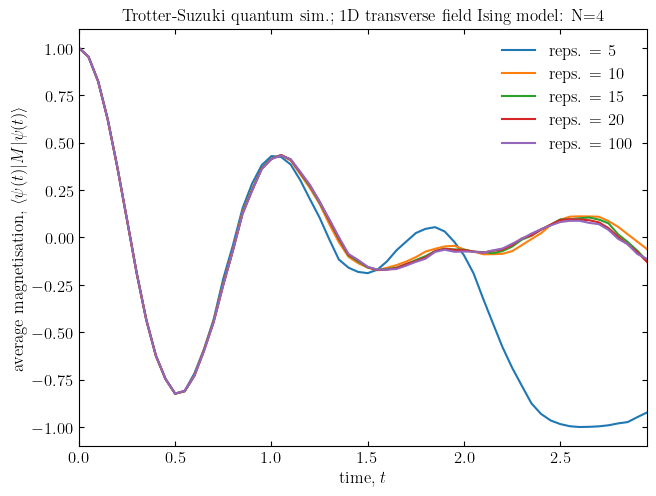

In [10]:
# plot
# plt.plot(times,magnetizations_exact,label=f"Exact evolution")
# plt.plot(t_maxs,magnetizations_TS,label=f"Trotter-Suzuki decomposition (without Classiq)", lw=0, marker='o',color='k',markersize=5)
fig, ax = plt.subplots()
for id in range(len(repetitions_list)):
  ax.plot(times,magnetizations_cl_rep[id,:],label=f"reps. = {repetitions_list[id]}") #, marker='x',color='red',markersize=5)

# ax_inset = fig.add_axes([0.4, 0.7, 0.27, 0.27])  # [left, bottom, width, height]
# for id in range(len(repetitions_list)):
#   ax_inset.plot(times[3:],magnetizations_cl_rep[id,3:])
# ax_inset.set_ylim(-0.25,0.1)
# ax_inset.tick_params(direction='in')
# ax_inset.tick_params(top=True, right=True, which='major')


ax.set_xlim(0,times[-1])
ax.set_ylim(-1.1,1.1)
ax.tick_params(direction='in')
ax.tick_params(top=True, right=True, which='major')
ax.legend(frameon=False)
ax.set_xlabel(r'time, $t$')
ax.set_ylabel(r"average magnetisation, $\langle \psi(t)| M | \psi(t) \rangle$")
ax.set_title("Trotter-Suzuki quantum sim.; 1D transverse field Ising model: N=4")
plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=0.5)
# plt.savefig("name.png",dpi=300)
# plt.savefig("name.svg")
plt.show()

We examine different number of Trotter-Suzuki steps; reps.$=5,\,10,\,15,\,20,\,100$. For short scale dynamics from $t=0$ to $t=1$ all simulation's results are consistent.
For larger scale the results from the 5 repetition experiment starts divaraging from other results.
It is consistent with our expectations, since the longer the evolution time the more repetitions we need.
Based on the results, in the following simulations we select repetition number equal to 15 as the representative one.

### Different times and shots; repetitions=15

Here, we analyse how many shots (measurements) in the experiment we need to identify the system state;
for the 1D Ising model with $N=4$.

In [ ]:
times = np.arange(0.0,3,0.05)
shots_list = [500,1000,2000,5000,10000]

magnetizations_cl_shots = np.zeros((len(shots_list),len(times)))

# Parameters related to qcircuit and measurement
REPETITIONS = 15

for (jd,shots) in enumerate(shots_list):
  qcircuit = create_model(main)
  quantum_program = synthesize(qcircuit)

  # ExecuteSession for symbolic parameters
  exe_session = ExecutionSession(quantum_program, 
                                  ExecutionPreferences(
                                  num_shots=shots, job_name=f"suzuki-trotter", random_seed=767
                                ))
  # show(quantum_program)

  for (id,time) in enumerate(times):
    results = exe_session.sample({"time":time,"J":-1,"h":-3})

    # calculate magnetization
    data = results.counts
    state = [v/shots for v in data.values()]
    basis = list(data.keys())
    magnetizations_cl_shots[jd,id] = mz_total(basis,state)

In [11]:
# magnetizations_cl_shots 
# array([[ 1.     ,  0.954  ,  0.824  ,  0.617  ,  0.364  ,  0.076  ,
#         -0.192  , -0.444  , -0.638  , -0.764  , -0.833  , -0.823  ,
#         -0.742  , -0.611  , -0.461  , -0.251  , -0.084  ,  0.129  ,
#          0.243  ,  0.352  ,  0.403  ,  0.418  ,  0.407  ,  0.319  ,
#          0.247  ,  0.167  ,  0.082  , -0.024  , -0.107  , -0.136  ,
#         -0.169  , -0.184  , -0.172  , -0.174  , -0.157  , -0.135  ,
#         -0.111  , -0.09   , -0.068  , -0.083  , -0.082  , -0.085  ,
#         -0.091  , -0.092  , -0.09   , -0.07   , -0.025  ,  0.001  ,
#          0.027  ,  0.051  ,  0.085  ,  0.083  ,  0.091  ,  0.1    ,
#          0.082  ,  0.069  ,  0.008  , -0.025  , -0.076  , -0.144  ],
#        [ 1.     ,  0.9535 ,  0.8245 ,  0.6225 ,  0.3705 ,  0.0945 ,
#         -0.1855 , -0.432  , -0.623  , -0.746  , -0.8235 , -0.8115 ,
#         -0.7285 , -0.594  , -0.4415 , -0.2465 , -0.069  ,  0.1295 ,
#          0.251  ,  0.3645 ,  0.415  ,  0.4345 ,  0.4115 ,  0.341  ,
#          0.27   ,  0.184  ,  0.0905 , -0.008  , -0.0935 , -0.1265 ,
#         -0.1575 , -0.17   , -0.1665 , -0.1585 , -0.1405 , -0.119  ,
#         -0.0985 , -0.072  , -0.059  , -0.063  , -0.0645 , -0.075  ,
#         -0.077  , -0.083  , -0.0715 , -0.048  , -0.0115 ,  0.009  ,
#          0.0425 ,  0.067  ,  0.0955 ,  0.0955 ,  0.1015 ,  0.1055 ,
#          0.0945 ,  0.075  ,  0.017  , -0.0235 , -0.0695 , -0.123  ],
#        [ 1.     ,  0.95225,  0.825  ,  0.6215 ,  0.37075,  0.0945 ,
#         -0.18425, -0.4365 , -0.62625, -0.75575, -0.8235 , -0.81025,
#         -0.73725, -0.60225, -0.44   , -0.24175, -0.06625,  0.1205 ,
#          0.25175,  0.36   ,  0.415  ,  0.431  ,  0.40975,  0.34875,
#          0.26275,  0.17375,  0.08375, -0.00475, -0.0775 , -0.12125,
#         -0.1495 , -0.162  , -0.156  , -0.148  , -0.131  , -0.11075,
#         -0.0905 , -0.0675 , -0.06325, -0.065  , -0.06575, -0.073  ,
#         -0.07775, -0.08475, -0.0715 , -0.045  , -0.01675,  0.00725,
#          0.043  ,  0.073  ,  0.105  ,  0.11175,  0.12   ,  0.1105 ,
#          0.0995 ,  0.069  ,  0.01125, -0.02375, -0.068  , -0.1155 ],
#        [ 1.     ,  0.9564 ,  0.827  ,  0.6256 ,  0.3764 ,  0.1038 ,
#         -0.1699 , -0.4222 , -0.6206 , -0.754  , -0.8162 , -0.8064 ,
#         -0.7284 , -0.5934 , -0.424  , -0.2367 , -0.0483 ,  0.1277 ,
#          0.2664 ,  0.3702 ,  0.4262 ,  0.4361 ,  0.4136 ,  0.3517 ,
#          0.2777 ,  0.1856 ,  0.0923 ,  0.0075 , -0.063  , -0.1034 ,
#         -0.1342 , -0.1447 , -0.1378 , -0.1288 , -0.1094 , -0.0904 ,
#         -0.0705 , -0.0543 , -0.0505 , -0.0568 , -0.0632 , -0.0694 ,
#         -0.0756 , -0.07   , -0.0545 , -0.0378 , -0.0073 ,  0.022  ,
#          0.0528 ,  0.0816 ,  0.1116 ,  0.1258 ,  0.1329 ,  0.1239 ,
#          0.1048 ,  0.0757 ,  0.0339 , -0.0064 , -0.0539 , -0.0982 ],
#        [ 1.     ,  0.95475,  0.8268 ,  0.62505,  0.37745,  0.1001 ,
#         -0.16885, -0.4177 , -0.61685, -0.74845, -0.81285, -0.80395,
#         -0.7211 , -0.5925 , -0.42405, -0.2351 , -0.0495 ,  0.12615,
#          0.2669 ,  0.3678 ,  0.42535,  0.43845,  0.41355,  0.3539 ,
#          0.2808 ,  0.18495,  0.09345,  0.0095 , -0.05605, -0.10285,
#         -0.13285, -0.14335, -0.13965, -0.1267 , -0.1077 , -0.08565,
#         -0.06385, -0.04835, -0.04335, -0.0501 , -0.05535, -0.06265,
#         -0.06715, -0.0625 , -0.04975, -0.0327 , -0.00695,  0.02045,
#          0.05435,  0.08615,  0.1152 ,  0.1353 ,  0.1416 ,  0.1293 ,
#          0.10695,  0.07455,  0.0325 , -0.0079 , -0.05365, -0.0905 ]])

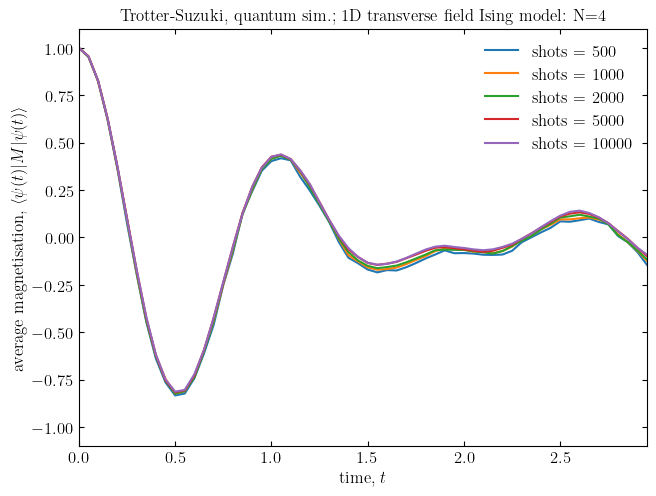

In [12]:
# plot
# plt.plot(times,magnetizations_exact,label=f"Exact evolution")
# plt.plot(t_maxs,magnetizations_TS,label=f"Trotter-Suzuki decomposition (without Classiq)", lw=0, marker='o',color='k',markersize=5)
fig, ax = plt.subplots()
for id in range(len(shots_list)):
  ax.plot(times,magnetizations_cl_shots[id,:],label=f"shots = {shots_list[id]}") #, marker='x',color='red',markersize=5)

# ax_inset = fig.add_axes([0.4, 0.7, 0.27, 0.27])  # [left, bottom, width, height]
# for id in range(len(repetitions_list)):
#   ax_inset.plot(times[3:],magnetizations_cl_rep[id,3:])
# ax_inset.set_ylim(-0.25,0.1)
# ax_inset.tick_params(direction='in')
# ax_inset.tick_params(top=True, right=True, which='major')


ax.set_xlim(0,times[-1])
ax.set_ylim(-1.1,1.1)
ax.tick_params(direction='in')
ax.tick_params(top=True, right=True, which='major')
ax.legend(frameon=False)
ax.set_xlabel(r'time, $t$')
ax.set_ylabel(r"average magnetisation, $\langle \psi(t)| M | \psi(t) \rangle$")
ax.set_title("Trotter-Suzuki, quantum sim.; 1D transverse field Ising model: N=4")
plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=0.5)
# plt.savefig("name.png",dpi=300)
# plt.savefig("name.svg")
plt.show()

We examine different number of shots (measurements) in the experiments ; shots $=500,\,1000,\,5000,\,10000$. Those results do not differ by much, and we believe that slight incosistencies between curves after $t=1$ can be attributed to the probabilistic nature of the measurements. To get consistent results, one can set the number of shots and repeat the experiment few times and average the results. For future measurementes we select shots$=1000$.

### Different times; repetitions=15, shots = 1000 (final results)

Here, we analyse the behaviour of 1D transverse-field Ising model probed by evoultion of magnetisation for selected parameters: shots $= 1000$ and $15$ repetitions of the Trotter-Suzuki block. We also compare the results with the exact evolution, and the evolution simulated using classical Trotter-Suzuki implementation.

Before switching to the final results, we discussed the architecture of our quantum circuits.

In [ ]:
# Show the quantum_program
REPETITIONS = 15

qcircuit = create_model(main)
quantum_program = synthesize(qcircuit)
show(quantum_program)

Opening: https://platform.classiq.io/circuit/0dace829-6c80-4b1a-ad54-3f2007763444?version=0.44.0


The quantum circuit consists of $N=4$ qubits, with the main building block being the Trotter-Suzuki (TS) decomposition. The initial state of the system is $|0\rangle^{\otimes N}$.
![qcircuit](../imgs/1D-Ising-model-Classiq-qcircuit.png)

The Trotter-Suzuki block is repeated $15$ times, here we show just the part of the circuit.
![qcircuit](../imgs/1D-Ising-model-Classiq-TS-repetitions.png)

Each Trotter-Suzuki block consists of the gates: Rz: 7, H: 8, CX: 8, and has depth: 9 and width: 4. 

It transpiled counterpart: U: 4, CX: 6, and depth: 7, width: 4. 
In the next section, we discussed the resources estimation for the 2D transverse-field Ising model.
The current model, we treat as a toy model to get the intuitions about the system and learned the building blocks of the quantum circuit.
![qcircuit](../imgs/1D-Ising-model-Classiq-one-TS-step-details.png)

In [ ]:
times = np.arange(0.0,3.,0.05)

magnetizations_cl = np.zeros(len(times))

# Parameters related to qcircuit and measurement
REPETITIONS = 15
shots = 1000

qcircuit = create_model(main)
quantum_program = synthesize(qcircuit)

# ExecuteSession for symbolic parameters
exe_session = ExecutionSession(quantum_program, 
                                ExecutionPreferences(
                                num_shots=shots, job_name=f"suzuki-trotter", random_seed=767
                              ))
# show(quantum_program)

for (id,time) in enumerate(times):
  results = exe_session.sample({"time":time,"J":-1,"h":-3})

  # calculate magnetization
  data = results.counts
  state = [v/shots for v in data.values()]
  basis = list(data.keys())
  magnetizations_cl[id] = mz_total(basis,state)

In [13]:
# magnetizations_cl 
# array([ 1.    ,  0.9535,  0.8245,  0.6225,  0.3705,  0.0945, -0.1855,
#        -0.432 , -0.623 , -0.746 , -0.8235, -0.8115, -0.7285, -0.594 ,
#        -0.4415, -0.2465, -0.069 ,  0.1295,  0.251 ,  0.3645,  0.415 ,
#         0.4345,  0.4115,  0.341 ,  0.27  ,  0.184 ,  0.0905, -0.008 ,
#        -0.0935, -0.1265, -0.1575, -0.17  , -0.1665, -0.1585, -0.1405,
#        -0.119 , -0.0985, -0.072 , -0.059 , -0.063 , -0.0645, -0.075 ,
#        -0.077 , -0.083 , -0.0715, -0.048 , -0.0115,  0.009 ,  0.0425,
#         0.067 ,  0.0955,  0.0955,  0.1015,  0.1055,  0.0945,  0.075 ,
#         0.017 , -0.0235, -0.0695, -0.123 ])

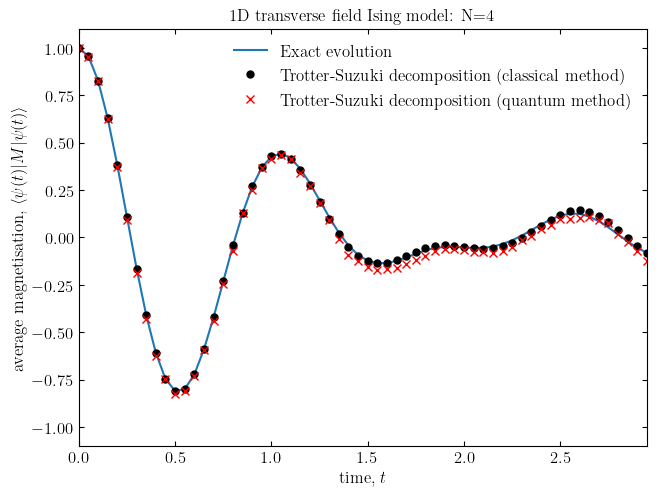

In [14]:
# plot
plt.plot(times,magnetizations_exact,label=f"Exact evolution")
plt.plot(times,magnetizations_TS,label=f"Trotter-Suzuki decomposition (classical method)", lw=0, marker='o',color='k',markersize=5)
plt.plot(times,magnetizations_cl,label=f"Trotter-Suzuki decomposition (quantum method)", lw=0,marker='x',color='red',markersize=6)
plt.xlim(0,times[-1])
plt.ylim(-1.1,1.1)
plt.tick_params(direction='in')
plt.tick_params(top=True, right=True, which='major')
plt.legend(frameon=False)
plt.xlabel(r'time, $t$')
plt.ylabel(r"average magnetisation, $\langle \psi(t)| M | \psi(t) \rangle$")
plt.title("1D transverse field Ising model: N=4")
plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=0.5)
# plt.savefig("name.png",dpi=300)
# plt.savefig("name.svg")
plt.show()

The final results of magnetization evolution in 1D transverse-field Ising model obtained using the exact approach, and Trotter-Suzuki decomposition (classical and quantum simulations). 
We set the Trotter-Suzuki repetitions block to $15$ and number of shots as $1000$.
For times $t>1.25$, these approaches start to differ. To improve the results,
one can play with the parameters of the quantum circuit and the number of repetitions of the Trotter-Suzuki blocks. The toy model, 1D transverse-field Ising model, shows that our approach is good and can be used to explore bigger systems (2D transverse-field Ising model) with larger number of qubits.

### Final comments

In this section, we analysed 1D transverse-field Ising model with $N=4$ spins without periodic boundary conditions. This model is easily scalable, including: larger dimension, more spins, more complicated coupling between the spins. Additionally, each coupling between spins can be controlled separetly, and the external magnetic field can be different on each site. In the subsequent section, we extend the model into 2D transverse-field model and optimize it accoridng to the width of the quantum cicuit.

# 3. Enlarge the problem

*Enlarged problem:* two-dimensional (2D) transverse-field Ising model with any connections, external magnetic field values, and coupling strengths.

*Steps*

The steps replicate the approach presented in the previous section, but now they are extended into a more flexible model.

1. Simulate the evolution of the system using the exact approach, and calculate the magnetisation for the evolved state.
2. Simulate the evolution of the system using the Trotter-Suzuki decomposition (quantum method), and calculate the magnetisation for the evolved state.
3. Discuss the circuit depth, circuit width and number of 2-qubit gates.

We initially analyse the 2D transverse-field Ising system with $N=3\times M=3$ spins. We assume the following connections between spins:

![qcircuit](../PROJECT-Classiq/imgs/2D-Ising-model-cartoon.png)

## 3.1 Exact dynamics of 2D Ising model

In [2]:
# Parameters of the system
N = 3 # number of spins in row
M = 3 # number of spins in column

CONNECTIONS= [
    [0,1],
    [1,2],
    [2,3],
    [3,4],
    [4,5],
    [5,6],
    [6,7],
    [7,8],
    [1,4],
    [4,7]
    ] # connections between spins
Js = [1]*len(CONNECTIONS)   # coupling constants
hs = [-3]*N*M  # external magnetic field

In [16]:
# Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
# Identity matrix
I = np.eye(2, dtype=complex)


def construct_hamiltonian(connections, N, M, Js, hs):
    """
    Construct the Hamiltonian for the 2D Ising model in a transverse field

    Input
    -----
    connections (list): list of connections between spins
    N (int): number of spins in a row
    M (int): number of spins in a column 
    Js (list): list of coupling strengths
    hs (list): list of external magnetic field strengths

    Output
    ------
    H (np.array): matrix that represents the 1D transverse-field Ising model 
    """

    H = np.zeros((2**(N*M), 2**(N*M)), dtype=complex)

    # H_X term of the Hamiltonian
    for id in range(N*M):
        operators = [I]*(N*M)
        operators[id] = sigma_x
        term = operators[0]
        for op in operators[1:]:
            term = np.kron(term,op)
        H += hs[id] * term

    # X_ZZ term of the Hamiltonian
    for (id, connection) in enumerate(connections):
        operators = [I]*(N*M)
        operators[connection[0]] = sigma_z
        operators[connection[1]] = sigma_z
        term = operators[0]
        for op in operators[1:]:
            term = np.kron(term,op)
        H -= Js[id] * term

    return H

def compute_magnetization(state, N, M):
    """
    Compute the magnetization for the given state.

    Input
    -----
    state (np.array): state for which the magnetization is calculated
    N (int): number of spins in a row
    M (int): number of spins in a column 

    Output
    ------
    (float): average magnetization for a given state
    """
    magnetization = 0
    for i in range(N*M):
        operators = [I]*(N*M)
        operators[i] = sigma_z
        term = operators[0]
        for op in operators[1:]:
            term = np.kron(term, op)
        magnetization += np.real(np.dot(state.conj().T, np.dot(term, state)))
    return magnetization / (N*M)

def bit_rep(num:int,N:int,M:int) -> str:
    """
    Binary representation of the given integer 'num', 
    padded to length 'N' of the system 

    Input
    -----
    num (int): number that is converted to binary
    N (int): number of spins in a row
    M (int): number of spins in a column 
    
    Output
    ------
    (str): binary number representation
    """
    return bin(num)[2:].zfill(N*M)

def generate_basis(N:int, M:int) -> list[str]:
    """
    Generates a basis spanning the Hilbert space of N spins

    Input
    -----
        N (int): number of spins in a row
    M (int): number of spins in a column 

    Output
    ------
    (list(str)): list of the basis states
    """
    nstates = 2**(N*M)
    basis = []
    for i in range(nstates):
        basis.append(bit_rep(i, N, M))
    return basis

In [ ]:
# Parameters
t_max = 3     # Maximum time
dt = 0.05       # Time step

# Initial state: all spins up
initial_state = np.zeros(2**(N*M), dtype=complex)
initial_state[0] = 1.0

# Construct the Hamiltonian
H = construct_hamiltonian(CONNECTIONS, N, M, Js, hs)

# Time evolution and magnetization calculation
times = np.arange(0, t_max, dt)
magnetizations_exact = np.zeros(len(times))

for (id,t) in enumerate(times):
    U = expm(-1j * H * t)
    state_t = np.dot(U, initial_state)
    magnetizations_exact[id] = compute_magnetization(state_t,N,M)

In [18]:
# magnetizations_exact
# array([ 1.        ,  0.95554743,  0.82845291,  0.63547694,  0.39915465,
#         0.14321436, -0.10996817, -0.34008975, -0.5292942 , -0.66331674,
#        -0.73324096, -0.73682097, -0.67851614, -0.56827908, -0.41979167,
#        -0.24878201, -0.07159905,  0.09608584,  0.24055987,  0.35125962,
#         0.42166382,  0.44967807,  0.43741108,  0.39040581,  0.3165457 ,
#         0.2249263 ,  0.12491007,  0.02541054, -0.06567904, -0.14198309,
#        -0.19902393, -0.23438113, -0.24759799, -0.23992438, -0.21402428,
#        -0.17370193, -0.12359808, -0.06878468, -0.01426658,  0.03550402,
#         0.0769846 ,  0.10773287,  0.12646996,  0.13307256,  0.12850275,
#         0.11461057,  0.093749  ,  0.06829224,  0.04031117,  0.01159655,
#        -0.01606622, -0.04068999, -0.06020424, -0.07288675, -0.0778521 ,
#        -0.07530293, -0.06643085, -0.0530798 , -0.03735161, -0.02123797])

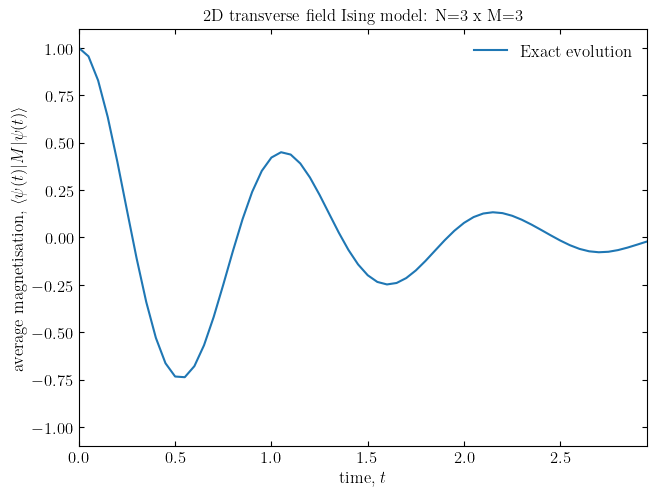

In [19]:
# Plot
plt.plot(times,magnetizations_exact,label=f"Exact evolution")
plt.xlim(0,times[-1])
plt.ylim(-1.1,1.1)
plt.tick_params(direction='in')
plt.tick_params(top=True, right=True, which='major')
plt.legend(frameon=False)
plt.xlabel(r'time, $t$')
plt.ylabel(r"average magnetisation, $\langle \psi(t)| M | \psi(t) \rangle$")
plt.title(f"2D transverse field Ising model: N={N} x M={M}")
plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=0.5)
# plt.savefig("name.png",dpi=300)
# plt.savefig("name.svg")
plt.show()

## 3.2 Approximated dynamics of 2D Ising model (quantum simulation)

In [3]:
# Parameters of the Suzuki-Trotter decomposition
REPETITIONS = 1000

N = 3 # number of spins in row
M = 3 # number of spins in column

# Parameters of the system
CONNECTIONS= [
    [0,1],
    [1,2],
    [2,3],
    [3,4],
    [4,5],
    [5,6],
    [6,7],
    [7,8],
    [1,4],
    [4,7]
    ] # connections between spins
Js = [1]*len(CONNECTIONS)   # coupling constants
hs = [-3]*N*M  # external magnetic field

In [4]:
def get_repetitions():
  """
  Just returns the global variable repetitions;
  allows us to control the 'repetitions' parameter
  as a function variable.
  """
  return REPETITIONS

def get_connections():
  """
  Just returns the global variable connections -- which spins are coupled;
  allows us to control the 'connections' parameter
  as a function variable.
  """
  return CONNECTIONS

def get_Js():
  """
  Just returns the global variable Js -- coupling between spins;
  allows us to control the 'Js' parameter
  as a function variable.
  """
  return Js

def get_hs():
  """
  Just returns the global variable hs -- external magnetic field;
  allows us to control the 'hs' parameter
  as a function variable.
  """
  return hs

def get_N():
  """
  Just returns the global variable N -- number of spins in a row;
  allows us to control the 'N' parameter
  as a function variable.
  """
  return N

def get_M():
  """
  Just returns the global variable M --  number of spin in a column;
  allows us to control the 'M' parameter
  as a function variable.
  """
  return M

def mz_state(basis):
    """
    Calculate the magnetization of a given state in the basis.

    Input
    -----
    basis (str): a state from the basis
    N (int): number of spins

    Output
    ------
    mz (int): magnetization of a given state
    """
    mz = 0
    for id in range(len(basis)):
        mz += (1-2*int(basis[id]))
    return mz

def mz_total(basis,state,N_tot):
    """
    Calculate the total magnetization for a given state.

    Input
    -----
    basis (str): computational basis for N=4 spins
    state (np.array): the state in which the magnetization is calculated
    N (int): number of spins

    Output
    ------
    (float): the total magnetization of a system
    """
    mz_total = 0
    for jd in range(len(basis)):
        mz_total += state[jd] * mz_state(basis[jd])
    return mz_total/N_tot

In [7]:
# Defining the Hamiltonian
def get_hamiltonian(connections,N,M,J,h):
  """
  Generate the 2D Ising Hamiltonian for NxM spins for given connections.
  The external field 'h' can varied from site to site, 
  and the coupling strength 'J' between spins can be different.

  Input
  -----
  connections (list): list of connections between spins
  N (int): number of rows
  M (int): number of columns
  J (list): interaction strength for given connections
  h (list): transverse field strength

  Output
  ------
  hamiltonian (np.array): Hamiltonian for NxM spins
  """
  hamiltonian = []

  for (id,connection) in enumerate(connections):
      term_zz = [Pauli.I] * (N*M)
      term_zz[connection[0]] = Pauli.Z
      term_zz[connection[1]] = Pauli.Z
      hamiltonian.append(PauliTerm(term_zz, J[id]))

  for id in range(N*M):
      term_x = [Pauli.I] * (N*M)
      term_x[id] = Pauli.X
      hamiltonian.append(PauliTerm(term_x, h[id]))

  return hamiltonian

In [5]:
@qfunc
def main(time:CReal,qreg: Output[QArray]):
    # Parameters of the system
    N = get_N() # number of spins in row
    M = get_M() # number of spins in column
    Js = get_Js()
    hs = get_hs()
    CONNECTIONS = get_connections()

    # Parameters of the system's dynamics
    REPETITIONS = get_repetitions()
    order = 1

    # Create a qcircuit
    allocate(N*M,qreg) # initial state |0,0,0,...>

    suzuki_trotter(
        get_hamiltonian(CONNECTIONS,N,M,Js,hs),
        evolution_coefficient=time,
        repetitions=REPETITIONS,
        order=order,
        qbv=qreg,
    )

### Different times and repetitions; shots=1000

Here, we analyse how many repetitions of the Trotter-Suzuki decompositions blocks we need
for the 2D Ising model with $N=3 \times M=3$ spins.

In [ ]:
times = np.arange(0.0,3,0.05)
repetitions_list = [5,10,15,20,100]
N_tot = M*N

magnetizations_cl_rep = np.zeros((len(repetitions_list),len(times)))

# Parameters related to qcircuit and measurement
shots = 1000

for (jd,REPETITIONS) in enumerate(repetitions_list):
  qcircuit = create_model(main)
  quantum_program = synthesize(qcircuit)

  # ExecuteSession for symbolic parameters
  exe_session = ExecutionSession(quantum_program,
                                  ExecutionPreferences(
                                  num_shots=shots, job_name=f"suzuki-trotter-2D-Ising", random_seed=767
                                ))
  # show(quantum_program)

  for (id,time) in enumerate(times):
    results = exe_session.sample({"time":time})

    # calculate magnetization
    data = results.counts
    state = [v/shots for v in data.values()]
    basis = list(data.keys())
    magnetizations_cl_rep[jd,id] = mz_total(basis,state,N_tot)

In [21]:
# magnetizations_cl_rep 
# array([[ 1.        ,  0.95288889,  0.82688889,  0.62177778,  0.39133333,
#          0.12288889, -0.12777778, -0.36444444, -0.54622222, -0.68555556,
#         -0.73577778, -0.72888889, -0.65644444, -0.52622222, -0.36622222,
#         -0.20466667, -0.03      ,  0.11911111,  0.26      ,  0.30866667,
#          0.336     ,  0.33022222,  0.32377778,  0.25555556,  0.19111111,
#          0.12355556,  0.03911111, -0.01688889, -0.07311111, -0.108     ,
#         -0.11733333, -0.11377778, -0.10577778, -0.082     , -0.03822222,
#          0.00466667,  0.03088889,  0.06844444,  0.08844444,  0.07755556,
#          0.03355556, -0.03711111, -0.11555556, -0.20622222, -0.33155556,
#         -0.44444444, -0.57155556, -0.67622222, -0.77888889, -0.87244444,
#         -0.93511111, -0.98133333, -0.99866667, -0.99577778, -0.97377778,
#         -0.92866667, -0.86688889, -0.79133333, -0.70644444, -0.61333333],
#        [ 1.        ,  0.95311111,  0.82622222,  0.62044444,  0.39955556,
#          0.13577778, -0.124     , -0.35422222, -0.54777778, -0.676     ,
#         -0.74066667, -0.73977778, -0.67866667, -0.56044444, -0.42266667,
#         -0.23266667, -0.058     ,  0.10311111,  0.26222222,  0.33244444,
#          0.37555556,  0.41133333,  0.37577778,  0.34466667,  0.28666667,
#          0.19644444,  0.10066667,  0.00577778, -0.06222222, -0.10888889,
#         -0.15955556, -0.198     , -0.20955556, -0.20466667, -0.19777778,
#         -0.17333333, -0.15244444, -0.108     , -0.04288889, -0.03155556,
#          0.02155556,  0.03555556,  0.05955556,  0.08133333,  0.07666667,
#          0.05622222,  0.05311111,  0.052     ,  0.03022222,  0.01911111,
#          0.01533333,  0.00288889, -0.00933333, -0.01      , -0.02844444,
#         -0.024     , -0.03866667, -0.04      , -0.04066667, -0.04377778],
#        [ 1.        ,  0.95311111,  0.82644444,  0.62      ,  0.40088889,
#          0.13377778, -0.11866667, -0.35644444, -0.54133333, -0.67311111,
#         -0.74533333, -0.73755556, -0.68622222, -0.56666667, -0.43511111,
#         -0.23511111, -0.07244444,  0.09333333,  0.25022222,  0.33266667,
#          0.39133333,  0.42911111,  0.40711111,  0.35577778,  0.29466667,
#          0.21533333,  0.08911111,  0.00333333, -0.05577778, -0.14044444,
#         -0.18066667, -0.21711111, -0.24822222, -0.242     , -0.21111111,
#         -0.19577778, -0.15933333, -0.11666667, -0.04088889, -0.00777778,
#          0.02022222,  0.06488889,  0.10577778,  0.11155556,  0.11511111,
#          0.09155556,  0.07933333,  0.05866667,  0.03244444,  0.01844444,
#         -0.02133333, -0.02511111, -0.06044444, -0.076     , -0.07266667,
#         -0.08333333, -0.084     , -0.09733333, -0.09644444, -0.07977778],
#        [ 1.        ,  0.95311111,  0.82622222,  0.62088889,  0.40066667,
#          0.13622222, -0.11488889, -0.35688889, -0.54266667, -0.674     ,
#         -0.74177778, -0.73911111, -0.68666667, -0.56711111, -0.43622222,
#         -0.24244444, -0.08044444,  0.104     ,  0.254     ,  0.32911111,
#          0.402     ,  0.42644444,  0.42222222,  0.36533333,  0.29888889,
#          0.22088889,  0.096     ,  0.00644444, -0.06555556, -0.14533333,
#         -0.20044444, -0.24422222, -0.26666667, -0.25044444, -0.22555556,
#         -0.19311111, -0.16377778, -0.12066667, -0.04      , -0.00711111,
#          0.04733333,  0.07133333,  0.09844444,  0.10822222,  0.11133333,
#          0.11177778,  0.08422222,  0.07444444,  0.03488889,  0.00533333,
#         -0.02755556, -0.05977778, -0.07088889, -0.08688889, -0.08511111,
#         -0.09577778, -0.10311111, -0.09288889, -0.08622222, -0.06888889],
#        [ 1.        ,  0.95311111,  0.82644444,  0.62177778,  0.39955556,
#          0.13511111, -0.11666667, -0.35266667, -0.53888889, -0.67022222,
#         -0.74222222, -0.74577778, -0.68911111, -0.57022222, -0.44355556,
#         -0.25755556, -0.09111111,  0.08866667,  0.25333333,  0.336     ,
#          0.40133333,  0.43133333,  0.42222222,  0.37222222,  0.31133333,
#          0.21511111,  0.09355556,  0.02022222, -0.08511111, -0.15888889,
#         -0.21288889, -0.26111111, -0.25844444, -0.24866667, -0.23533333,
#         -0.18533333, -0.16355556, -0.09555556, -0.04133333,  0.02888889,
#          0.04933333,  0.10355556,  0.11577778,  0.148     ,  0.13266667,
#          0.10644444,  0.07288889,  0.04688889,  0.02577778, -0.00644444,
#         -0.04488889, -0.07377778, -0.088     , -0.10266667, -0.10244444,
#         -0.09533333, -0.08688889, -0.08622222, -0.05511111, -0.03444444]])

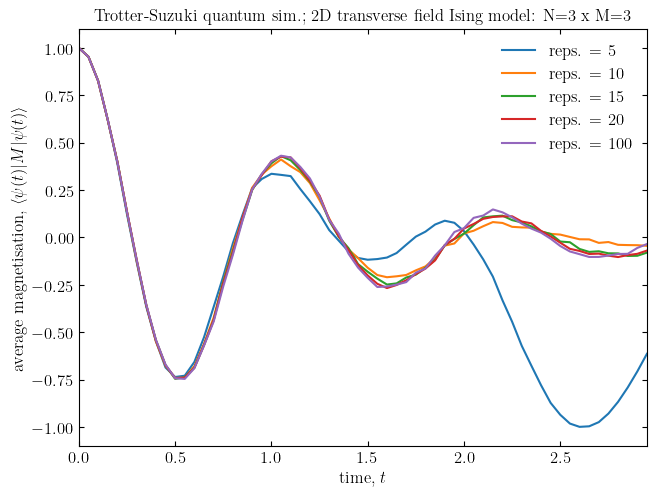

In [22]:
# plot
# plt.plot(times,magnetizations_exact,label=f"Exact evolution")
# plt.plot(t_maxs,magnetizations_TS,label=f"Trotter-Suzuki decomposition (without Classiq)", lw=0, marker='o',color='k',markersize=5)
fig, ax = plt.subplots()
for id in range(len(repetitions_list)):
  ax.plot(times,magnetizations_cl_rep[id,:],label=f"reps. = {repetitions_list[id]}") #, marker='x',color='red',markersize=5)

# ax_inset = fig.add_axes([0.4, 0.7, 0.27, 0.27])  # [left, bottom, width, height]
# for id in range(len(repetitions_list)):
#   ax_inset.plot(times[3:],magnetizations_cl_rep[id,3:])
# ax_inset.set_ylim(-0.25,0.1)
# ax_inset.tick_params(direction='in')
# ax_inset.tick_params(top=True, right=True, which='major')


ax.set_xlim(0,times[-1])
ax.set_ylim(-1.1,1.1)
ax.tick_params(direction='in')
ax.tick_params(top=True, right=True, which='major')
ax.legend(frameon=False)
ax.set_xlabel(r'time, $t$')
ax.set_ylabel(r"average magnetisation, $\langle \psi(t)| M | \psi(t) \rangle$")
ax.set_title(f"Trotter-Suzuki quantum sim.; 2D transverse field Ising model: N={N} x M={M}")
plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=0.5)
# plt.savefig("name.png",dpi=300)
# plt.savefig("name.svg")
plt.show()

We examine different number of repetition steps of the Trotter-Suzuki block; reps.$=5,\,10,\,15,\,20,\,100$. For short scale dynamics from $t=0$ to $t=1$ all simulation's results are consistent.
For larger scale the results related to 5 repetitions starts divarage from the other results.
It is consistent with our expectations, since the longer evolution time the more repetitions we need.
In contrast to the 1D Ising model with $N=4$ spins presented in the previous section, the Hilbert space is spanned by $2^{N*M}$ states. We expect that a larger number of shots (measurements) is needed to properly characterize the final state. We focus on this ascpect in the next section, keeping number of repetitions equal to $15$.

### Different times and shots; repetitions=15

Here, we analyse how many shots (measurements) in the experiment we need to identify the system state;
for the 2D Ising model with $N=3 \times M=3$ spins.

In [ ]:
times = np.arange(0.0,3,0.05)
shots_list = [1000,5000,10000, 15000]
N_tot = M*N

magnetizations_cl_shots = np.zeros((len(shots_list),len(times)))

# Parameters related to qcircuit and measurement
REPETITIONS = 15

for (jd,shots) in enumerate(shots_list):
  qcircuit = create_model(main)
  quantum_program = synthesize(qcircuit)

  # ExecuteSession for symbolic parameters
  exe_session = ExecutionSession(quantum_program,
                                  ExecutionPreferences(
                                  num_shots=shots, job_name=f"suzuki-trotter", random_seed=767
                                ))
  # show(quantum_program)

  for (id,time) in enumerate(times):
    results = exe_session.sample({"time":time})

    # calculate magnetization
    data = results.counts
    state = [v/shots for v in data.values()]
    basis = list(data.keys())
    magnetizations_cl_shots[jd,id] = mz_total(basis,state, N_tot)

In [23]:
# magnetizations_cl_shots 
# array([[ 1.00000000e+00,  9.53111111e-01,  8.26444444e-01,
#          6.20000000e-01,  4.00888889e-01,  1.33777778e-01,
#         -1.18666667e-01, -3.56444444e-01, -5.41333333e-01,
#         -6.73111111e-01, -7.45333333e-01, -7.37555556e-01,
#         -6.86222222e-01, -5.66666667e-01, -4.35111111e-01,
#         -2.35111111e-01, -7.24444444e-02,  9.33333333e-02,
#          2.50222222e-01,  3.32666667e-01,  3.91333333e-01,
#          4.29111111e-01,  4.07111111e-01,  3.55777778e-01,
#          2.94666667e-01,  2.15333333e-01,  8.91111111e-02,
#          3.33333333e-03, -5.57777778e-02, -1.40444444e-01,
#         -1.80666667e-01, -2.17111111e-01, -2.48222222e-01,
#         -2.42000000e-01, -2.11111111e-01, -1.95777778e-01,
#         -1.59333333e-01, -1.16666667e-01, -4.08888889e-02,
#         -7.77777778e-03,  2.02222222e-02,  6.48888889e-02,
#          1.05777778e-01,  1.11555556e-01,  1.15111111e-01,
#          9.15555556e-02,  7.93333333e-02,  5.86666667e-02,
#          3.24444444e-02,  1.84444444e-02, -2.13333333e-02,
#         -2.51111111e-02, -6.04444444e-02, -7.60000000e-02,
#         -7.26666667e-02, -8.33333333e-02, -8.40000000e-02,
#         -9.73333333e-02, -9.64444444e-02, -7.97777778e-02],
#        [ 1.00000000e+00,  9.55688889e-01,  8.26044444e-01,
#          6.31644444e-01,  4.00444444e-01,  1.39066667e-01,
#         -1.14800000e-01, -3.42133333e-01, -5.40800000e-01,
#         -6.70177778e-01, -7.40044444e-01, -7.39111111e-01,
#         -6.75377778e-01, -5.62533333e-01, -4.17422222e-01,
#         -2.35066667e-01, -6.48000000e-02,  1.04977778e-01,
#          2.43555556e-01,  3.47466667e-01,  4.09555556e-01,
#          4.32311111e-01,  4.15555556e-01,  3.65644444e-01,
#          2.97955556e-01,  2.06444444e-01,  1.13733333e-01,
#          2.47111111e-02, -5.32000000e-02, -1.28044444e-01,
#         -1.74000000e-01, -2.10400000e-01, -2.35466667e-01,
#         -2.28488889e-01, -2.13066667e-01, -1.79866667e-01,
#         -1.45600000e-01, -9.76000000e-02, -4.63111111e-02,
#          8.88888889e-04,  3.67111111e-02,  7.46222222e-02,
#          1.05155556e-01,  1.15600000e-01,  1.16311111e-01,
#          1.05555556e-01,  9.24000000e-02,  7.94222222e-02,
#          5.55111111e-02,  3.09777778e-02, -2.22222222e-04,
#         -1.81333333e-02, -3.23111111e-02, -5.16444444e-02,
#         -6.27111111e-02, -7.16000000e-02, -7.82666667e-02,
#         -8.19111111e-02, -7.32444444e-02, -6.26666667e-02],
#        [ 1.00000000e+00,  9.55488889e-01,  8.28111111e-01,
#          6.32977778e-01,  3.99777778e-01,  1.38288889e-01,
#         -1.12044444e-01, -3.44955556e-01, -5.37577778e-01,
#         -6.68066667e-01, -7.36688889e-01, -7.38177778e-01,
#         -6.73311111e-01, -5.60755556e-01, -4.15355556e-01,
#         -2.33822222e-01, -6.12444444e-02,  1.03111111e-01,
#          2.43244444e-01,  3.52133333e-01,  4.14488889e-01,
#          4.36600000e-01,  4.20444444e-01,  3.70177778e-01,
#          2.95244444e-01,  2.07355556e-01,  1.14888889e-01,
#          2.48888889e-02, -5.48666667e-02, -1.26444444e-01,
#         -1.74244444e-01, -2.06377778e-01, -2.30355556e-01,
#         -2.30466667e-01, -2.13088889e-01, -1.79222222e-01,
#         -1.42466667e-01, -9.60666667e-02, -4.92000000e-02,
#         -2.40000000e-03,  3.79555556e-02,  7.12000000e-02,
#          9.72888889e-02,  1.11600000e-01,  1.12444444e-01,
#          1.04577778e-01,  9.27777778e-02,  8.01777778e-02,
#          5.61333333e-02,  3.48000000e-02,  8.84444444e-03,
#         -1.32666667e-02, -3.20666667e-02, -5.27555556e-02,
#         -6.26666667e-02, -7.13111111e-02, -7.60666667e-02,
#         -7.55777778e-02, -7.00444444e-02, -6.07333333e-02],
#        [ 1.00000000e+00,  9.56474074e-01,  8.28681481e-01,
#          6.34651852e-01,  3.99777778e-01,  1.42533333e-01,
#         -1.08711111e-01, -3.41881481e-01, -5.34800000e-01,
#         -6.65200000e-01, -7.35703704e-01, -7.36029630e-01,
#         -6.71866667e-01, -5.59837037e-01, -4.09644444e-01,
#         -2.30681481e-01, -5.75111111e-02,  1.10800000e-01,
#          2.47451852e-01,  3.54177778e-01,  4.17525926e-01,
#          4.38607407e-01,  4.23762963e-01,  3.74548148e-01,
#          2.98518519e-01,  2.12740741e-01,  1.21111111e-01,
#          3.06962963e-02, -4.76148148e-02, -1.19140741e-01,
#         -1.69125926e-01, -2.02162963e-01, -2.24207407e-01,
#         -2.24651852e-01, -2.06814815e-01, -1.73037037e-01,
#         -1.34696296e-01, -9.04444444e-02, -4.38962963e-02,
#          4.34074074e-03,  4.49481481e-02,  7.58814815e-02,
#          1.02844444e-01,  1.17451852e-01,  1.18429630e-01,
#          1.09303704e-01,  9.74074074e-02,  8.43703704e-02,
#          6.42370370e-02,  4.24296296e-02,  1.56740741e-02,
#         -6.69629630e-03, -2.62666667e-02, -4.52444444e-02,
#         -5.61037037e-02, -6.65037037e-02, -6.94666667e-02,
#         -6.80592593e-02, -6.41333333e-02, -5.53185185e-02]])

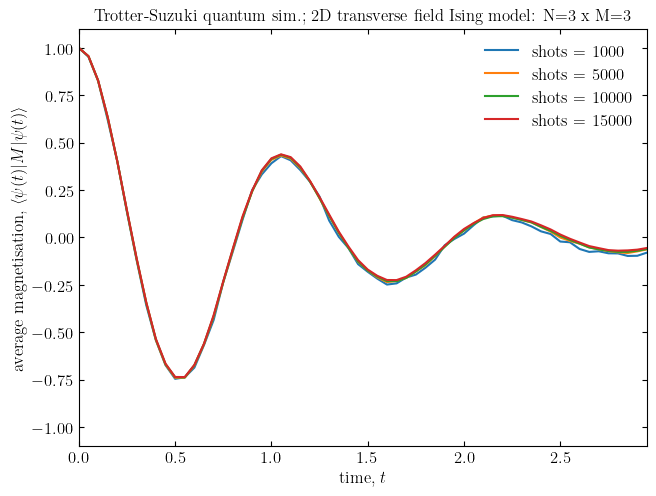

In [24]:
# plot
# plt.plot(times,magnetizations_exact,label=f"Exact evolution")
# plt.plot(t_maxs,magnetizations_TS,label=f"Trotter-Suzuki decomposition (without Classiq)", lw=0, marker='o',color='k',markersize=5)
fig, ax = plt.subplots()
for id in range(len(shots_list)):
  ax.plot(times,magnetizations_cl_shots[id,:],label=f"shots = {shots_list[id]}") #, marker='x',color='red',markersize=5)

# ax_inset = fig.add_axes([0.4, 0.7, 0.27, 0.27])  # [left, bottom, width, height]
# for id in range(len(repetitions_list)):
#   ax_inset.plot(times[3:],magnetizations_cl_rep[id,3:])
# ax_inset.set_ylim(-0.25,0.1)
# ax_inset.tick_params(direction='in')
# ax_inset.tick_params(top=True, right=True, which='major')


ax.set_xlim(0,times[-1])
ax.set_ylim(-1.1,1.1)
ax.tick_params(direction='in')
ax.tick_params(top=True, right=True, which='major')
ax.legend(frameon=False)
ax.set_xlabel(r'time, $t$')
ax.set_ylabel(r"average magnetisation, $\langle \psi(t)| M | \psi(t) \rangle$")
ax.set_title(f"Trotter-Suzuki quantum sim.; 2D transverse field Ising model: N={N} x M={M}")
plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=0.5)
# plt.savefig("name.png",dpi=300)
# plt.savefig("name.svg")
plt.show()

We examine different number of shots (measurements) in the experiments ; shots $=1000,\,5000,\,10000,\,20000$. For further experiments we set number of shots equal to $5000$.

### Different times; repetitions=15, shots = 5000 (final results)

Here, we analyse the behaviour of 2D transverse-field Ising model using magnetization evolution for selected parameters: shots $= 5000$ and $15$ repetitions of the Trotter-Suzuki block. We also compare the results with the exact evolution, and the evolution simulated using a classical implementation of Trotter-Suzuki decomposition.

In [ ]:
times = np.arange(0.0,3.,0.05)

magnetizations_cl = np.zeros(len(times))

# Parameters related to qcircuit and measurement
REPETITIONS = 15
shots = 5000

qcircuit = create_model(main)
quantum_program = synthesize(qcircuit)

# ExecuteSession for symbolic parameters
exe_session = ExecutionSession(quantum_program,
                                ExecutionPreferences(
                                num_shots=shots, job_name=f"suzuki-trotter", random_seed=767
                              ))
# show(quantum_program)

for (id,time) in enumerate(times):
  results = exe_session.sample({"time":time})

  # calculate magnetization
  data = results.counts
  state = [v/shots for v in data.values()]
  basis = list(data.keys())
  magnetizations_cl[id] = mz_total(basis,state,N_tot)

In [25]:
# magnetizations_cl 
# array([ 1.00000000e+00,  9.55688889e-01,  8.26044444e-01,  6.31644444e-01,
#         4.00444444e-01,  1.39066667e-01, -1.14800000e-01, -3.42133333e-01,
#        -5.40800000e-01, -6.70177778e-01, -7.40044444e-01, -7.39111111e-01,
#        -6.75377778e-01, -5.62533333e-01, -4.17422222e-01, -2.35066667e-01,
#        -6.48000000e-02,  1.04977778e-01,  2.43555556e-01,  3.47466667e-01,
#         4.09555556e-01,  4.32311111e-01,  4.15555556e-01,  3.65644444e-01,
#         2.97955556e-01,  2.06444444e-01,  1.13733333e-01,  2.47111111e-02,
#        -5.32000000e-02, -1.28044444e-01, -1.74000000e-01, -2.10400000e-01,
#        -2.35466667e-01, -2.28488889e-01, -2.13066667e-01, -1.79866667e-01,
#        -1.45600000e-01, -9.76000000e-02, -4.63111111e-02,  8.88888889e-04,
#         3.67111111e-02,  7.46222222e-02,  1.05155556e-01,  1.15600000e-01,
#         1.16311111e-01,  1.05555556e-01,  9.24000000e-02,  7.94222222e-02,
#         5.55111111e-02,  3.09777778e-02, -2.22222222e-04, -1.81333333e-02,
#        -3.23111111e-02, -5.16444444e-02, -6.27111111e-02, -7.16000000e-02,
#        -7.82666667e-02, -8.19111111e-02, -7.32444444e-02, -6.26666667e-02])

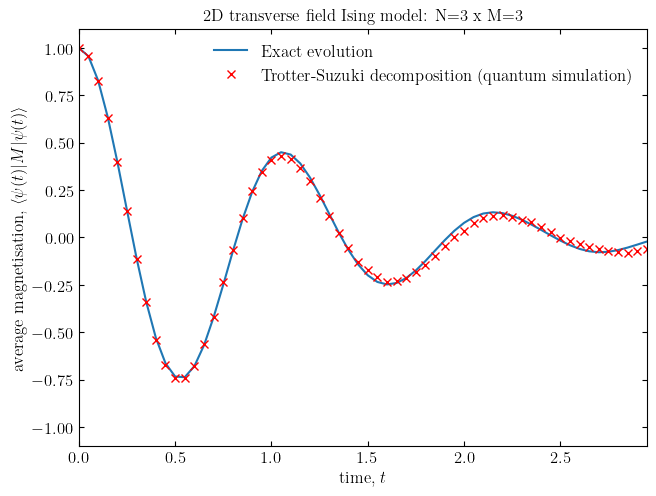

In [26]:
# plot
plt.plot(times,magnetizations_exact,label=f"Exact evolution")
plt.plot(times,magnetizations_cl,label=f"Trotter-Suzuki decomposition (quantum simulation)", lw=0,marker='x',color='red',markersize=6)
plt.xlim(0,times[-1])
plt.ylim(-1.1,1.1)
plt.tick_params(direction='in')
plt.tick_params(top=True, right=True, which='major')
plt.legend(frameon=False)
plt.xlabel(r'time, $t$')
plt.ylabel(r"average magnetisation, $\langle \psi(t)| M | \psi(t) \rangle$")
plt.title(f"2D transverse field Ising model: N={N} x M={M}")
plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=0.5)
# plt.savefig("name.png",dpi=300)
# plt.savefig("name.svg")
plt.show()

The final results of the magnetization over time for the 2D transverse-field Ising model obtained using the exact approach, and Trotter-Suzuki decomposition ( employing a quantum circuit). 
We set the Trotter-Suzuki repetitions block equal to $15$ and number of shots as $5000$.
For times $t>1.5$ the quantum simulation diverges from the exact solution . To improve the results one can play with the parameters of the quantum circuit and the number of repetitions of the Trotter-Suzuki blocks.

## 3.3 Resources estimation

Here, we analyse the number of 2-qubit gates, the width and the depth of the circuit for different number of the Trotter-Suzuki blocks.

In [31]:
times = [1]
repetitions_list = [1,5,10,15,20,25,30,35,40]
N_tot = M*N

depth_list = np.arange(len(repetitions_list))
width_list = np.arange(len(repetitions_list))
cx_list = np.arange(len(repetitions_list))

# Parameters related to qcircuit and measurement
shots = 1000

for (jd,REPETITIONS) in enumerate(repetitions_list):
    qcircuit = create_model(main)
    quantum_program = synthesize(qcircuit)

    info = QuantumProgram.from_qprog(quantum_program)
    depth_list[jd] = info.transpiled_circuit.depth
    width_list[jd] = info.data.width
    cx_list[jd] = info.transpiled_circuit.count_ops["cx"]

    print(f"REPETITIONS: {REPETITIONS}")
    info = QuantumProgram.from_qprog(quantum_program)
    print(f"Depth: {info.transpiled_circuit.depth}")
    print(f"Count ops: {info.transpiled_circuit.count_ops}")
    print(f"Width: {info.data.width}\n")


REPETITIONS: 1
Depth: 15
Count ops: {'cx': 20, 'rz': 19, 'h': 18}
Width: 9

REPETITIONS: 5
Depth: 75
Count ops: {'cx': 100, 'rz': 95, 'h': 90}
Width: 9

REPETITIONS: 10
Depth: 150
Count ops: {'cx': 200, 'rz': 190, 'h': 180}
Width: 9

REPETITIONS: 15
Depth: 225
Count ops: {'cx': 300, 'rz': 285, 'h': 270}
Width: 9

REPETITIONS: 20
Depth: 300
Count ops: {'cx': 400, 'rz': 380, 'h': 360}
Width: 9

REPETITIONS: 25
Depth: 375
Count ops: {'cx': 500, 'rz': 475, 'h': 450}
Width: 9

REPETITIONS: 30
Depth: 450
Count ops: {'cx': 600, 'rz': 570, 'h': 540}
Width: 9

REPETITIONS: 35
Depth: 525
Count ops: {'cx': 700, 'rz': 665, 'h': 630}
Width: 9

REPETITIONS: 40
Depth: 600
Count ops: {'cx': 800, 'rz': 760, 'h': 720}
Width: 9



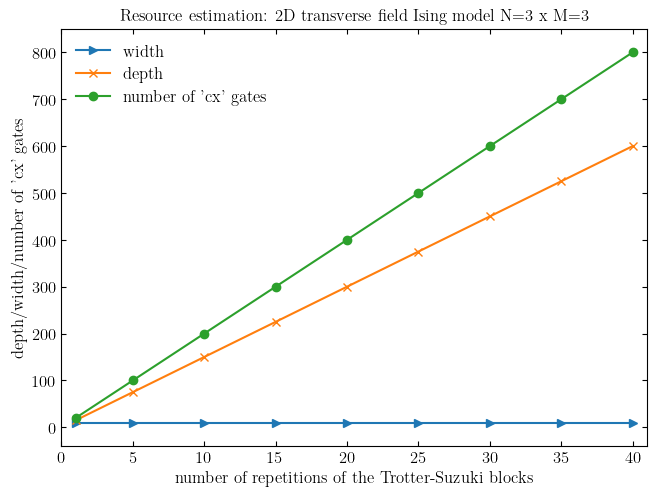

In [42]:
# plot
plt.plot(repetitions_list,width_list,label=f"width", marker='>',markersize=6)
plt.plot(repetitions_list,depth_list,label=f"depth", marker='x',markersize=6)
plt.plot(repetitions_list,cx_list,label=f"number of 'cx' gates", marker='o',markersize=6)
plt.xlim(0,repetitions_list[-1]+1)
plt.ylim(-40,850)
plt.tick_params(direction='in')
plt.tick_params(top=True, right=True, which='major')
plt.legend(frameon=False)
plt.xlabel(r'number of repetitions of the Trotter-Suzuki blocks')
plt.ylabel(r"depth/width/number of 'cx' gates")
plt.title(f"Resource estimation: 2D transverse field Ising model N={N} x M={M}")
plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=0.5)
# plt.savefig("name.png",dpi=300)
# plt.savefig("name.svg")
plt.show()

To simulate the dynamics of 2D Ising model we use the Trotter-Suzuki blocks. For given number of spins $N\times M$, the width of the circuits is constant and equal to $N*M$.
The circuit consists of the following gates: 1-qubit gates {'h','rz'} and 2-qubit gates {'cx'}. 
We focus on how number of 'cx' gates changes as the number of repetitions of the Trotter-Suzuki block grows,
since the 2-qubit gates introduce larger error in the results of a quantum computation than the 1-qubit gates.
The number of 'cx' gates changes linearly with the number of repetitions. 
The same behaviour is observed for the circuit depth but the slope is larger.


In this section, we present the results for 2D Ising model with $9$ spins and 15 Trotter-Suzuki repetitions.
The circuit characterization:
Depth: 225, 
Gates: {'cx': 300, 'rz': 285, 'h': 270}, 
Width: 9.

We try to oprimize the circuit according to the width and depth using the code below. The results are following:

**OPTIMIZATION according to the WIDTH**

REPETITIONS: 15, 
Depth: 225, 
Gates: {'cx': 300, 'rz': 285, 'h': 270}, 
Width: 9

**OPTIMIZATION according to the DEPTH**

REPETITIONS: 15, 
Depth: 225, 
Gates: {'cx': 300, 'rz': 285, 'h': 270}, 
Width: 9

Since the circuit consist of the Trotter-Suzuki blocks only, there is no effect of the optimization.

In [119]:
N_tot = M*N

REPETITIONS = 15

qcircuit = create_model(main)
print("OPTIMIZATION according to the WIDTH")
qcircuit = set_constraints(
    qcircuit,
    Constraints(optimization_parameter="width")
)
quantum_program = synthesize(qcircuit)

info = QuantumProgram.from_qprog(quantum_program)

print(f"REPETITIONS: {REPETITIONS}")
info = QuantumProgram.from_qprog(quantum_program)
print(f"Depth: {info.transpiled_circuit.depth}")
print(f"Gates: {info.transpiled_circuit.count_ops}")
print(f"Width: {info.data.width}\n")

##############################################
qcircuit = create_model(main)
print("OPTIMIZATION according to the DEPTH")
qcircuit = set_constraints(
    qcircuit,
    Constraints(optimization_parameter="depth")
)
quantum_program = synthesize(qcircuit)

info = QuantumProgram.from_qprog(quantum_program)

print(f"REPETITIONS: {REPETITIONS}")
info = QuantumProgram.from_qprog(quantum_program)
print(f"Depth: {info.transpiled_circuit.depth}")
print(f"Gates: {info.transpiled_circuit.count_ops}")
print(f"Width: {info.data.width}\n")


OPTIMIZATION according to the WIDTH
REPETITIONS: 15
Depth: 225
Gates: {'cx': 300, 'rz': 285, 'h': 270}
Width: 9

OPTIMIZATION according to the DEPTH
REPETITIONS: 15
Depth: 225
Gates: {'cx': 300, 'rz': 285, 'h': 270}
Width: 9



Having all results, we decide to run the circuit for the maximum number of qubits in the Classiq simulator; $N*M=25$.
For 15 repetitions of the Trotter-Suzuki blocks the circuit is characterized by: 
Depth: 315, 
Gates: {'cx': 1200, 'rz': 975, 'h': 750}, and
Width: 25.
We cannot compare the results with the exact simulations due to the Hilbert space, $2^{NM}$, growing too large for our simulations.

In [27]:
N = 5
M = 5

CONNECTIONS = []
for id in range(N*M-1):
    CONNECTIONS.append([id,id+1])
rest_connections = [[0,9],[1,8],[2,7],[3,6],[5,14],[6,13],[7,12],[8,11],[10,15],[11,16],[12,17],[13,18],[19,24],[18,23],[17,23],[16,21]]

for connection in rest_connections:  
    CONNECTIONS.append(connection)

Js = [1]*len(CONNECTIONS)   # coupling constants
hs = [-3]*N*M  # external magnetic field

In [ ]:
times = np.arange(0.0,3.,0.05)
N_tot = N*M

magnetizations_cl = np.zeros(len(times))

# Parameters related to qcircuit and measurement
REPETITIONS = 15
shots = 5000

qcircuit = create_model(main)
quantum_program = synthesize(qcircuit)

# ExecuteSession for symbolic parameters
exe_session = ExecutionSession(quantum_program,
                                ExecutionPreferences(
                                num_shots=shots, job_name=f"suzuki-trotter", random_seed=767
                              ))
# show(quantum_program)

for (id,time) in enumerate(times):
  results = exe_session.sample({"time":time})

  # calculate magnetization
  data = results.counts
  state = [v/shots for v in data.values()]
  basis = list(data.keys())
  magnetizations_cl[id] = mz_total(basis,state,N_tot)

In [28]:
# magnetizations_cl 
# array([ 1.      ,  0.95472 ,  0.829984,  0.642912,  0.422368,  0.195952,
#        -0.029936, -0.231968, -0.408944, -0.539632, -0.614816, -0.643968,
#        -0.623216, -0.552976, -0.457344, -0.329136, -0.19512 , -0.059888,
#         0.088848,  0.202208,  0.295248,  0.359312,  0.396688,  0.394192,
#         0.364576,  0.310752,  0.24128 ,  0.152   ,  0.058624, -0.027952,
#        -0.097168, -0.15664 , -0.2004  , -0.22368 , -0.223536, -0.21568 ,
#        -0.19792 , -0.142128, -0.100096, -0.059408, -0.002192,  0.0272  ,
#         0.066976,  0.082112,  0.09472 ,  0.097296,  0.092272,  0.081504,
#         0.07168 ,  0.053104,  0.029936,  0.00976 , -0.008064, -0.022384,
#        -0.047344, -0.04168 , -0.056464, -0.05128 , -0.047952, -0.040336])

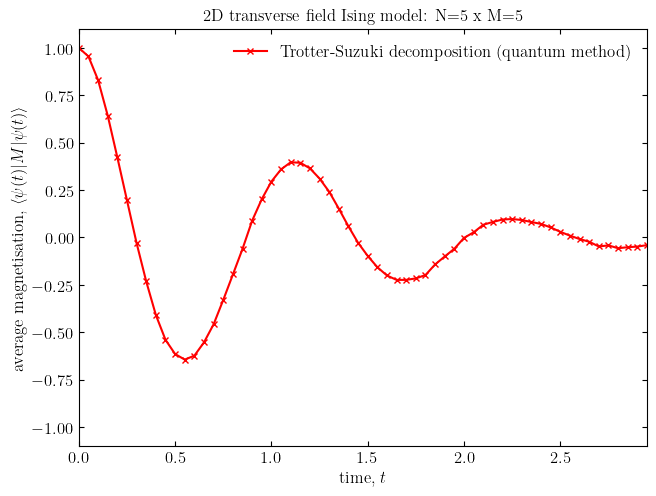

In [29]:
# plot
# plt.plot(times,magnetizations_exact,label=f"Exact evolution")
# plt.plot(t_maxs,magnetizations_TS,label=f"Trotter-Suzuki decomposition (without Classiq)", lw=0, marker='o',color='k',markersize=5)
plt.plot(times,magnetizations_cl,label=f"Trotter-Suzuki decomposition (quantum method)", marker='x',color='red',markersize=5)
plt.xlim(0,times[-1])
plt.ylim(-1.1,1.1)
plt.tick_params(direction='in')
plt.tick_params(top=True, right=True, which='major')
plt.legend(frameon=False)
plt.xlabel(r'time, $t$')
plt.ylabel(r"average magnetisation, $\langle \psi(t)| M | \psi(t) \rangle$")
plt.title(f"2D transverse field Ising model: N={N} x M={N}")
plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=0.5)
# plt.savefig("name.png",dpi=300)
# plt.savefig("name.svg")
plt.show()

# 4. Optimize the solution according to the hardware

Here, we discuss the optimization of the circuit according to the hardware. Since the dynamics of the 2D Ising model consist of the Trotter-Suzuki blocks which are already optimized, we cannot do more to optimize the circuit itself. However, we can adapt the connections available in the hardware to the ones in the Ising model.

The 2D transverse-field Ising model describes a system with coupling between nearest-neighbor spins. When using different hardware, it is necessary to adjust these connections according to the specific hardware configuration. For example, IonQ hardware allows for all-to-all connectivity, but the number of qubits due to this connectivity is limited (11, 25, 36, and 35 for IonQ Harmony, IonQ Aria, Forte, and Forte Enterprise QPU, respectively) [1]. In contrast, IBM hardware consists of only linear connectivity architecture but offers more qubits (156, 133, and many QPUs with 127 qubits). Due to the nearest-neighbor connectivity required by the Ising model, the latter hardware is more suitable for simulating that particular system. However, the available connections in the hardware are limited, as in the case of IBM Fez [2]:

![connectivity](../imgs/2D-Ising-model-IBM-FEZ.png)

(source: https://quantum.ibm.com/services/resources?system=ibm_fez; copyright: IBM).

According to the connections available in the hardware, we rewrite the connections in the Ising model to optimize the solution, as follows:

![connectivity](../imgs/2D-Ising-model-ibm-hardware.png)

keeping the maximum number of the qubits allowed by the Classiq ($N*M=25$).

[1] https://ionq.com/quantum-systems/compare

[2] https://quantum.ibm.com/services/resources

In [100]:
N = 5
M = 5

CONNECTIONS = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10],[10,11],[11,12],[12,13],[13,14],[14,15],
               [3,16],[7,17],[11,18],[15,19],[20,21],[21,22],[22,23],[23,24],[16,23]]


Js = [1]*len(CONNECTIONS)   # coupling constants
hs = [-3]*(N*M)  # external magnetic field

In [ ]:
times = np.arange(0.0,3.,0.05)

magnetizations_cl = np.zeros(len(times))

# Parameters related to qcircuit and measurement
REPETITIONS = 15
shots = 5000

qcircuit = create_model(main)
write_qmod(qcircuit,"2D-Ising-model-5x5-ibm-hardware")
quantum_program = synthesize(qcircuit)
show(quantum_program)

# ExecuteSession for symbolic parameters
exe_session = ExecutionSession(quantum_program,
                                ExecutionPreferences(
                                num_shots=shots, job_name=f"suzuki-trotter", random_seed=767
                              ))
# show(quantum_program)

for (id,time) in enumerate(times):
  results = exe_session.sample({"time":time})

  # calculate magnetization
  data = results.counts
  state = [v/shots for v in data.values()]
  basis = list(data.keys())
  magnetizations_cl[id] = mz_total(basis,state,N_tot)

In [108]:
times = [1]
repetitions_list = [15]
N_tot = M*N

for (jd,REPETITIONS) in enumerate(repetitions_list):
    qcircuit = create_model(main)
    quantum_program = synthesize(qcircuit)

    info = QuantumProgram.from_qprog(quantum_program)

    print(f"REPETITIONS: {REPETITIONS}")
    info = QuantumProgram.from_qprog(quantum_program)
    print(f"Depth: {info.transpiled_circuit.depth}")
    print(f"Gates: {info.transpiled_circuit.count_ops}")
    print(f"Width: {info.data.width}\n")

REPETITIONS: 15
Depth: 180
Gates: {'h': 750, 'rz': 735, 'cx': 720}
Width: 25



Above we prepare the codes for simulating dynamics of the 2D transverse-field Ising model with the connections between spins adjusted to those available on the IBM hardware (ibm_fez). This circuit is characterized by: depth 180, width 25, and 'cx' gates 720.

# 5. Noise mitigation (discussion)

Paper ["Evidence for the utility of quantum computing before fault tolerance"](https://www.nature.com/articles/s41586-023-06096-3) uses the trotterized evolution in Ising model to showcase how Zero-Noise Extrapolation (ZNE) can be used for accurate Hamiltonian simulation beyond what current classical supercomputers can do using exact diagonalization.
In this section we sketch the idea behind ZNE employing qiskit and pennylane for simulating noisy hardware. We use these tools for quick prototyping as classiq simulator does not have a readily available noisy gate function. As we note later however, the tools we employ can be transferred 1:1 to the classiq platform. Concretely, we model our noisy gates using pennylane's DepolarizingChannel function which works using Kraus gates. These can be implemented in the classiq platform as a set of non-unitary gates using LCU method. Here we focus on the straight-forward ZNE implementation leaving full classiq implementation for the future work.

[1] https://pennylane.ai/qml/demos/tutorial_mitigation_advantage/

## 5.1 Noisy hardware and ZNE

Real-world gates are inherently noisy. This behavior can be simulated with pennylane's DepolarizingChannel decorator inserted into the simulated quantum device. To simulate the error rate of 0.5% we set the depolarization probabilty $p = 0.005$. The value cited in the paper as 0.1% is enough to demonstrate very low fiedelity, but not high enough to meaningfuly demonstrate deterioration of expectation values. 
We note that Kraus gates from pennylane.DepolarizingChannel can be equally well modelled in classiq to simulate noisy hardware, i.e. the following work is 1:1 reproducible using classiq simulators employing the right depolarizing circuit.

For computation on real quantum hardware one must construct a quantum circuit to (1) learn the real noise distribution, (2) amplify the noise and (3) extrapolate to ideal zero-noise conditions.

Presented here is a simple apporach allowing us to cleanly showcase ZNE as we have full control over the noise amplification setting $p$ to the desired value.

## 5.2 Ideal vs. noisy simulation

For this simulation we employ the same connectivity diagram as in ##3.1. However, we use the trotterized circuit following ["Evidence for the utility of quantum computing before fault tolerance"](https://www.nature.com/articles/s41586-023-06096-3) with the definitions following the paper's notation:


Quantum evolution:

\begin{align*}
\lvert \psi(t) \rangle = U(t) \lvert \psi(0) \rangle = e^{-iHt/\hbar} \lvert \psi(0) \rangle
\end{align*}

Simplifing with Suzuki-Trotter decomposition

\begin{align*}
U(t) \approx \left( e^{\left(-i \sigma_{ZZ} \Delta t / \hbar\right)} e^{\left(-i \sigma_X \Delta t / \hbar\right)} \right)^N
\end{align*}

That's how it translates to components for the 1D Ising Hamiltonian:
\begin{align*}
e^{-i \sigma_{ZZ} \delta t} &= \prod_{\langle i,j \rangle} e^{i J \delta t Z_i Z_j} = \prod_{\langle i,j \rangle} R_{Z_i Z_j}(-2 J \delta t), \\
e^{-i \sigma_{X} \delta t} &= \prod_{i} e^{-i h \delta t X_i} = \prod_{i} R_{X_i}(2 h \delta t),
\end{align*}

with the following values and definitions:
\begin{align*}
\theta_j = -2J \delta t = -\pi/2, \\
\theta_h = 2h \delta t.
\end{align*}

![connectivity](../imgs/2d-ising-pennylane-noisy-vs-ideal.png)

In this plot we show the evolution of total magnetization as a function of $\theta_h$. The blue curve is a result of simulated quantum computation on a fault-free hardware with connectivity diagram given by the Hamiltonian. The orange curve is a result of the same experiment run on a simluated "noisy" hardware with depolarizing channel added to every gate. This is the noise we will attempt to mittigate.

## 5.3 Zero-noise extrapolation

Given the previous result we can create two more circuits with $p_1 = 1.2p$ and $p_2 = 1.6p$ (values taken from the paper). Then for each value $\theta_h$ we perform quadratic extrapolation to values of noise gain $G=0$. Those results are used in the next section to create the ZNE mittigated plot. 

![connectivity](../imgs/2d-ising-pennylane-noise-gain.png)

## 5.3 Error-mittigated data

Using the same approach as in 5.2 for each $\theta_h(i)$ we fit a noise gain model to every $\langle M(\theta_h(i)) \rangle$ to extrapolate a zero-noise value which we use to correct the $p$ noise data and compare it to the exact noise-free circuit.

![connectivity](../imgs/2d-ising-pennylane-noise-mitigation.png)

We note that this approach is markedly easier than the one presented in the original IBM paper. First of all, we only simulated our noise without assuming a noise model, since we know our noise exactly. Secondly, as a consequence of the first note, we did not have to devise a new parts of the circuit to learn the noise model of the real hardware for future amplification.

As we can see, for the values used here ZNE method works very well, exactly reproducing the original data.

# 6. Summary

In this work we explored 1D and 2D Ising model's magnetization evolution using exact classical methods, Trotter-Suzuki decomposition and trotterized quantum circuit simulations.

We focused on exploring capabilities provided by Classiq platform to generate, run and optimize quantum circuits. Using these results we selected best-fitting real-world quantum hardware for this Hamiltonian simulation.

In the last section we briefly explored the idea of mittigating noisy quantum hardware by method of zero-noise extrapolation.

## Acknowledgments

We express our gratitude towards the Quantum Womanium for the opportunity to parttake in a challanging and rewarding workshop. Thank you for all the effort and hard work poured to make it all work.